本檔案使用資料處理後的病史資料，使用機器學習演算法進行進行訓練與預測

並使用訓練好的三個模型（存好的三個權重'sincnet.h5','mfcc.h5','mels.h5')與三個機器學習演算法（SVM,ExtraTree,XGB）進行集成

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import confusion_matrix, classification_report, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras_self_attention import SeqSelfAttention
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D,Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dropout,Layer,Concatenate,Input,Activation
from tensorflow.keras.layers import BatchNormalization,LayerNormalization,LeakyReLU,ReLU,Add,AveragePooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D, Reshape, multiply, add, GlobalMaxPooling1D, Multiply
from tensorflow.keras.layers import Masking, Bidirectional, LSTM
from sincnet_tensorflow import SincConv1D
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

from focal_loss import SparseCategoricalFocalLoss

In [10]:
sample_rate = 16000
data = np.load('/home/user8008//sdk/sail/audio/cup/final/train_data(1000)(normalize).npz')
data_MFCC = np.load('/home/user8008/sdk/sail/audio/cup/final/MFCCtrain_data(1000).npz')
data_M = np.load('/home/user8008/sdk/sail/audio/cup/final/MelS(train).npz')

In [11]:
train_audio = data['train_audio']
train_clinical = data['train_clinical']
train_y = data['train_y']
train_y_bln =  data['train_y_bln']
train_MelS = data_M['MelS']
train_mfcc = data_MFCC['MFCC']

In [12]:
train_MelS_3 = np.stack((train_MelS, train_MelS, train_MelS), axis=3)
train_mfcc_3 = np.stack((train_mfcc, train_mfcc, train_mfcc), axis=3)

In [13]:
audio_x_train, audio_x_val, y_train, y_val = train_test_split(train_audio,train_y,test_size=0.2,random_state=5473,stratify=train_y_bln)
clinical_x_train, clinical_x_val, _,_ = train_test_split(train_clinical,train_y,test_size=0.2,random_state=5473,stratify=train_y_bln)
MelS_x_train, MelS_x_val, _,_ = train_test_split(train_MelS_3,train_y,test_size=0.2,random_state=5473,stratify=train_y_bln)
mfcc_x_train, mfcc_x_val, _,_ = train_test_split(train_mfcc_3,train_y,test_size=0.2,random_state=5473,stratify=train_y_bln)

In [15]:
def gelu(x):
    return 0.5 * x * (1.0 + K.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * x * x * x)))

def spatialAttention_eff(input_feature,kernel_size=7,name=""):
    cbam_feature=input_feature
    avg_pool=tf.reduce_mean(input_feature,axis=3,keepdims=True)
    max_pool=tf.reduce_max(input_feature,axis=3,keepdims=True)
    concat=Concatenate(axis=3)([avg_pool,max_pool])
    cbam_feature=Conv1D(filters=80,kernel_size=7,strides=1,padding='same',use_bias=False,name="spatial_attention_" + str(name), dilation_rate=2)(concat)
    cbam_feature=Activation('sigmoid')(cbam_feature)
    out=Multiply()([input_feature,cbam_feature])
    return out

def residual_block_eff(x, filters, conv_num=3, activation="relu"):
    s = Conv1D(filters, 1, padding="same", dilation_rate=12)(x)  # 5
    for i in range(conv_num - 1):

        x = Conv1D(filters, 3, padding="same", dilation_rate=12)(x)
        x = ReLU()(x)
        x = Conv1D(filters, 3, padding="same", dilation_rate=12)(x)
        x = Add()([x, s])
        x = ReLU()(x)
    return MaxPooling2D(pool_size=3, strides=2,name='residual_end')(x)


model_mfcc = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(43,43,3), pooling='max')  # avg
layer = tf.keras.models.Model(inputs=model_mfrom sklearn.metrics import fcc.input, outputs=model_mfcc.get_layer('block4c_project_conv').output)
x = layer.output
x = Dropout(0.25)(x)
x_sp = spatialAttention_eff(x,kernel_size=4,name="")
x = residual_block_eff(x_sp,8,3)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(1280,kernel_regularizer=regularizers.l2(0.001))(x)
x = gelu(x)
x = Dropout(0.1)(x)
x = Dense(128,kernel_regularizer=regularizers.l2(0.001))(x)
x = gelu(x)
output = Dense(units=5, activation='softmax')(x)
model_mfcc = tf.keras.models.Model(inputs=model_mfcc.input, outputs=output)

In [16]:
model_mfcc.load_weights('mfcc.h5')

In [17]:
def gelu(x):
    return 0.5 * x * (1.0 + K.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * x * x * x)))

def spatialAttention_eff(input_feature,kernel_size=7,name=""):
    cbam_feature=input_feature
    avg_pool=tf.reduce_mean(input_feature,axis=3,keepdims=True) from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
    max_pool=tf.reduce_max(input_feature,axis=3,keepdims=True)
    concat=Concatenate(axis=3)([avg_pool,max_pool])
    cbam_feature=Conv2D(filters=112,kernel_size=7,strides=1,padding='same',use_bias=False,name="spatial_attention_" + str(name), dilation_rate=2)(concat)
    cbam_feature=Activation('sigmoid')(cbam_feature)
    out=Multiply()([input_feature,cbam_feature])
    return out

def residual_block_eff(x, filters, conv_num=3, activation="relu"):
    s = Conv2D(filters, 1, padding="same", dilation_rate=12)(x)  # 5
    for i in range(conv_num - 1):
        x = Conv2D(filters, 3, padding="same", dilation_rate=12)(x)
        x = ReLU()(x)
        x = Conv2D(filters, 3, padding="same", dilation_rate=12)(x)
        x = Add()([x, s])
        x = ReLU()(x)
    return MaxPooling2D(pool_size=3, strides=2,name='residual_end')(x)


model_mels = EfficientNetB4(include_top=False, weights='imagenet', input_shape=(184,184,3), pooling='max')  # avg
layer = tf.keras.models.Model(inputs=model_mels.input, outputs=model_mels.get_layer('block4c_project_conv').output)
x = layer.output
x = Dropout(0.25)(x)
x_sp = spatialAttention_eff(x,kernel_size=4,name="")
x = residual_block_eff(x_sp,8,3)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(1280,kernel_regularizer=regularizers.l2(0.001))(x)
x = gelu(x)
x = Dropout(0.1)(x)
x = Dense(128,kernel_regularizer=regularizers.l2(0.001))(x)
x = gelu(x)
output = Dense(units=5, activation='softmax')(x)
model_mels = tf.keras.models.Model(inputs=model_mels.input, outputs=output)

In [18]:
model_mels.load_weights('mels.h5')

In [19]:
sinc_layer251 = SincConv1D(N_filt=60, Filt_dim=251, fs=sample_rate, stride=24, padding="SAME")
sinc_layer501 = SincConv1D(N_filt=60, Filt_dim=501, fs=sample_rate, stride=24, padding="SAME")
sinc_layer1001 = SincConv1D(N_filt=60, Filt_dim=1001, fs=sample_rate, stride=24, padding="SAME")

def residual_block(x, filters, conv_num=3, activation="relu"):
    s = Conv1D(filters, 1, padding="same", dilation_rate=12)(x)
    for i in range(conv_num - 1):
        x = Conv1D(filters, 3, padding="same", dilation_rate=12)(x)
        x = gelu(x)
        x = Conv1D(filters, 3, padding="same", dilation_rate=12)(x)
        x = Add()([x, s])
        x = gelu(x)
    return MaxPooling1D(pool_size=3, strides=2,name='residual_end')(x)

def channelAttention(input_feature,ratio=8,name=""):
    channel=input_feature.shape[-1]
    shared_layer_one=Dense(channel//ratio,activation='relu',use_bias=False,name="channel_attention_shared_one_" + str(name))
    shared_layer_two=Dense(channel,use_bias=False,name="channel_attention_shared_two_" + str(name))
    avg_pool=GlobalAveragePooling1D()(input_feature)
    max_pool=GlobalMaxPooling1D()(input_feature)
    avg_pool=Reshape((1,channel))(avg_pool)
    max_pool=Reshape((1,channel))(max_pool)
    avg_pool=shared_layer_one(avg_pool)
    max_pool=shared_layer_one(max_pool)
    avg_pool=shared_layer_two(avg_pool)
    max_pool=shared_layer_two(max_pool)
    cbam_feature=Add()([avg_pool,max_pool])
    cbam_feature=Activation('sigmoid')(cbam_feature)
    out=Multiply()([input_feature,cbam_feature])
    return out

def spatialAttention(input_feature,kernel_size=7,name=""):
    cbam_feature=input_feature
    avg_pool=tf.reduce_mean(input_feature,axis=2,keepdims=True)
    max_pool=tf.reduce_max(input_feature,axis=2,keepdims=True)
    concat=Concatenate(axis=2)([avg_pool,max_pool])
    cbam_feature=Conv1D(filters=1,kernel_size=7,strides=1,padding='same',use_bias=False,name="spatial_attention_" + str(name),dilation_rate=2)(concat)
    cbam_feature=Activation('sigmoid')(cbam_feature)
    out=Multiply()([input_feature,cbam_feature])
    return out

def cbamBlock(cbam_feature,ratio=8,name=""):
    cbam_feature=channelAttention(cbam_feature,ratio,name)
    cbam_feature=spatialAttention(cbam_feature,name)
    return cbam_featureGnb_proba

class TemporalAttention(keras.Model):
	def __init__(self,fin,fout=1):
		super(TemporalAttention,self).__init__()
		self.fin = fin 
		self.fout = fout 
		
		self.initializer = initializers.GlorotUniform() 
		self.w = tf.Variable(self.initializer(shape=[self.fin, self.fout], dtype=tf.float32))
	def call(self,h):
		x = h 
		alpha = h @ self.w 
		alpha = tf.nn.softmax(tf.tanh(alpha),1)
		x = tf.einsum('ijk,ijm->ikm', alpha, x) 
		return tf.squeeze(x,[1]) 
    
def gelu(x):
    return 0.5 * x * (1.0 + K.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * x * x * x)))

In [21]:
def build_model():
    inputs = Input((48000, 1))
    finput_shape_1 = Input((10,))
    x1 = sinc_layer251(inputs)
    x1 = Dropout(0.05)(x1)
    x2 = sinc_layer501(inputs)
    x2 = Dropout(0.05)(x2)
    x3 = sinc_layer1001(inputs)
    x3 = Dropout(0.05)(x3)
    x = Concatenate(name="ms_sincnet")([x1,x2,x3])
    x = MaxPooling1D(pool_size=3, name="MaxPooling")(x)
    x = LayerNormalization(name="Lnor1")(x)       
    xx = LeakyReLU(alpha=0.2)(x)
    x_sp = spatialAttention(xx,kernel_size=7,name="")
    x_ch = channelAttention(xx,ratio=10,name="")
    x = Concatenate(name="Concat_sp_and_ch")([x_sp,x_ch])
    x = Dropout(0.25)(x)
    x = residual_block(x,16,3)
    x = Masking(mask_value=0.0)(x)
    x = Bidirectional(LSTM(20, return_sequences=True))(x)
    x = SeqSelfAttention(attention_activation='sigmoid')(x)     
    x = TemporalAttention(40,1)(x)
    x = Dropout(0.25)(x)
    xf = Dense(300)(finput_shape_1)
    xf = gelu(xf)
    xf = Dropout(0.25)(xf)    
    xf = Dense(100)(xf)
    xf = gelu(xf)
    xf = Dense(25)(xf)
    xf = gelu(xf)
    x = Concatenate()([x, xf])
    x = Dense(8,kernel_regularizer=regularizers.l2(0.001))(x)
    x = gelu(x)

    outputs = Dense(5, activation="softmax", name="output")(x)
    return tf.keras.models.Model(inputs=[inputs,finput_shape_1],outputs=outputs)

In [22]:
model = build_model()
model.load_weights('sincnet.h5')

In [26]:
MelS_predict = model_mels.predict([MelS_x_val])
MelS_pred = np.argmax(MelS_predict, axis=-1)
print(classification_report(y_val, MelS_pred))

              precision    recall  f1-score   support

           0       0.63      0.87      0.73       107
           1       0.57      0.18      0.28        44
           2       0.70      0.62      0.66        34
           3       0.00      0.00      0.00         9
           4       0.71      0.83      0.77         6

    accuracy                           0.64       200
   macro avg       0.52      0.50      0.49       200
weighted avg       0.60      0.64      0.59       200



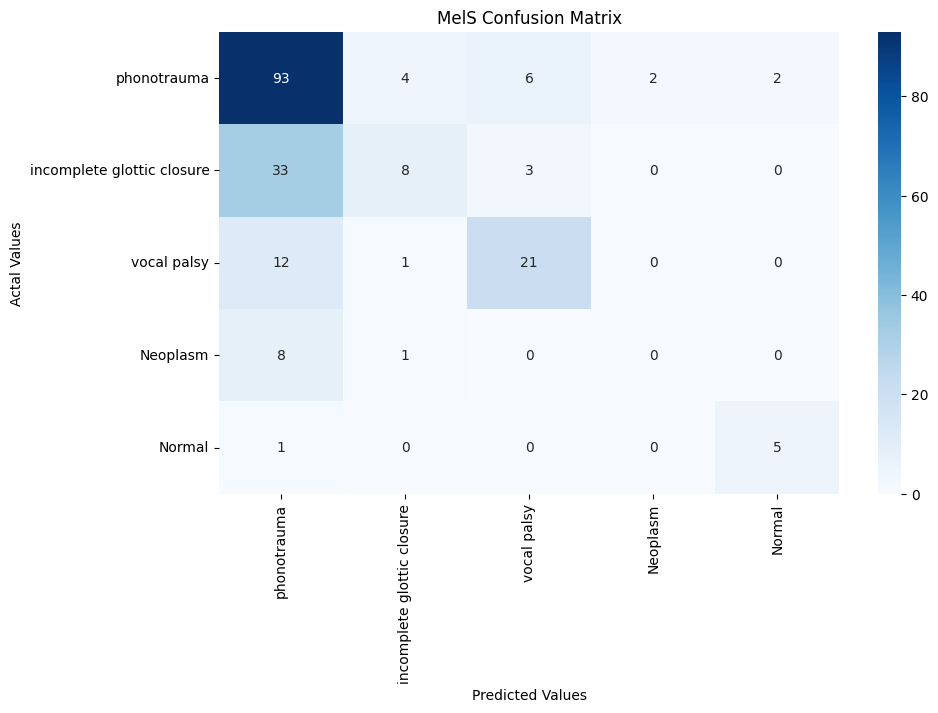

In [31]:
class_name = ['phonotrauma', 'incomplete glottic closure', 'vocal palsy', 'Neoplasm', 'Normal']
conf = confusion_matrix(y_val, MelS_pred)
cm_dfsinc = pd.DataFrame(conf,
                     index = class_name, 
                     columns = class_name)

plt.figure(figsize = (10, 6))
sns.heatmap(cm_dfsinc, annot=True,fmt="d", cmap='Blues')
plt.title('MelS Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [43]:
mfcc_predict = model_mfcc.predict([mfcc_x_val])  ########
mfcc_pred = np.argmax(mfcc_predict, axis=-1)
print(classification_report(y_val, mfcc_pred))

              precision    recall  f1-score   support

           0       0.59      0.82      0.68       107
           1       0.00      0.00      0.00        44
           2       0.37      0.47      0.42        34
           3       0.50      0.11      0.18         9
           4       0.40      0.33      0.36         6

    accuracy                           0.54       200
   macro avg       0.37      0.35      0.33       200
weighted avg       0.41      0.54      0.46       200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


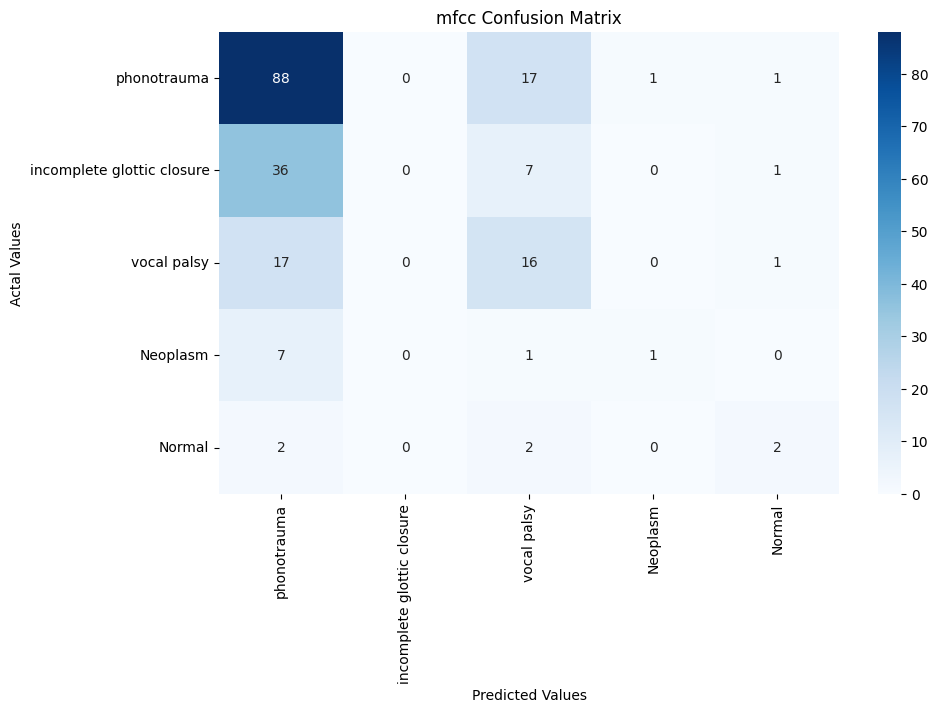

In [33]:
class_name = ['phonotrauma', 'incomplete glottic closure', 'vocal palsy', 'Neoplasm', 'Normal']
conf = confusion_matrix(y_val, mfcc_pred)
cm_dfsinc = pd.DataFrame(conf,
                     index = class_name, 
                     columns = class_name)

plt.figure(figsize = (10, 6))
sns.heatmap(cm_dfsinc, annot=True,fmt="d", cmap='Blues')
plt.title('mfcc Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [34]:
sincnet_predict = model.predict([audio_x_val,clinical_x_val])  ########
sincnet_pred = np.argmax(sincnet_predict, axis=-1)
print(classification_report(y_val, sincnet_pred))

              precision    recall  f1-score   support

           0       0.76      0.79      0.78       107
           1       0.41      0.52      0.46        44
           2       0.75      0.62      0.68        34
           3       0.00      0.00      0.00         9
           4       0.75      0.50      0.60         6

    accuracy                           0.66       200
   macro avg       0.53      0.49      0.50       200
weighted avg       0.65      0.66      0.65       200



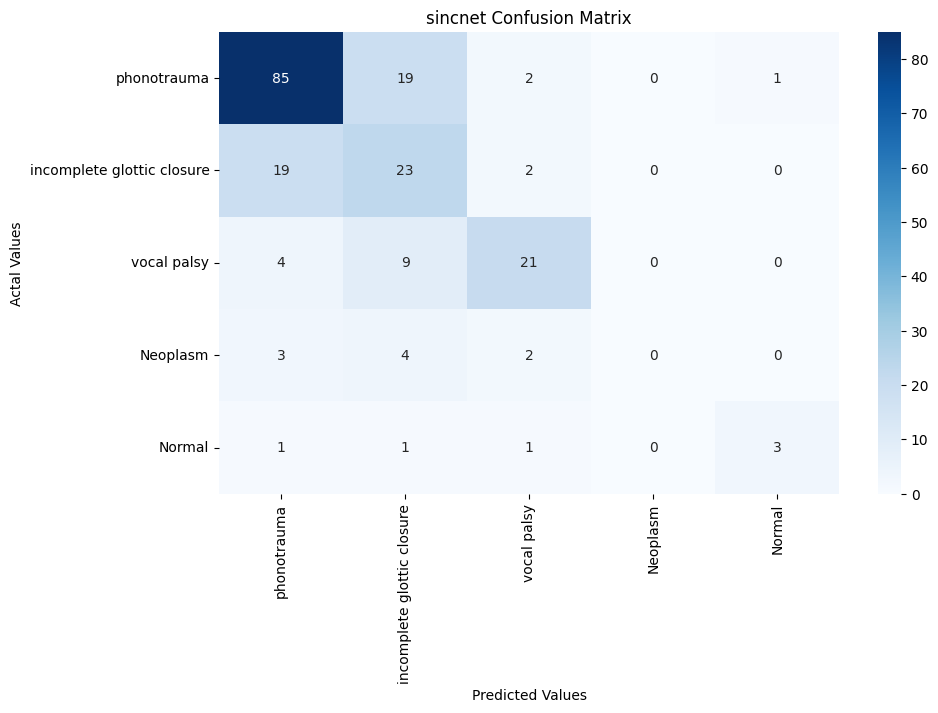

In [35]:
class_name = ['phonotrauma', 'incomplete glottic closure', 'vocal palsy', 'Neoplasm', 'Normal']
conf = confusion_matrix(y_val, sincnet_pred)
cm_dfsinc = pd.DataFrame(conf,
                     index = class_name, 
                     columns = class_name)

plt.figure(figsize = (10, 6))
sns.heatmap(cm_dfsinc, annot=True,fmt="d", cmap='Blues')
plt.title('sincnet Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [44]:
def specificity_sensitivity(y_test, y_pred):
    Ppp, Pip, Pvp, Pnp, PNop, Ppi, Pii, Pvi, Pni, PNoi, Ppv, Piv, Pvv, Pnv, PNov, Ppn, Pin, Pvn, Pnn, PNon, PpNo, PiNo, PvNo, PnNo, PNoNo = confusion_matrix(
                            y_test, y_pred).ravel()
    TP = PNoNo
    TN = Ppp + Pip + Pvp + Pnp + Ppi + Pii + Pvi + Pni + Ppv + Piv + Pvv + Pnv + Ppn + Pin + Pvn + Pnn
    FP = PNop + PNoi + PNov + PNon
    FN = PpNo + PiNo + PvNo + PnNo
    specificity = TN / (TN + FP)
    sensitivity =  TP/(TP + FN) 
    return specificity, sensitivity

In [ ]:
svm = SVC(kernel='linear', probability=True, class_weight = 'balanced',gamma='scale',C=0.15)
svm.fit(clinical_x_train,y_train)

clf = ExtraTreesClassifier(class_weight='balanced', criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None, min_impurity_decrease=0.0,min_samples_leaf=4, min_samples_split=5,n_estimators=200)
clf.fit(clinical_x_train,y_train)

xgb = XGBClassifier(learning_rate=0.01,  n_estimators=10, reg_alpha = 0.1, max_depth=8, gamma=0.4)
xgb.fit(clinical_x_train,y_train)

SVM
              precision    recall  f1-score   support

           0       0.85      0.63      0.72       107
           1       0.50      0.45      0.48        44
           2       0.62      0.68      0.65        34
           3       0.29      0.56      0.38         9
           4       0.15      0.67      0.24         6

    accuracy                           0.59       200
   macro avg       0.48      0.60      0.49       200
weighted avg       0.69      0.59      0.62       200

UAR: 0.5958812978604072
specificity:  0.8814432989690721
sensitivity:  0.6666666666666666
AUC 0.765295125295469


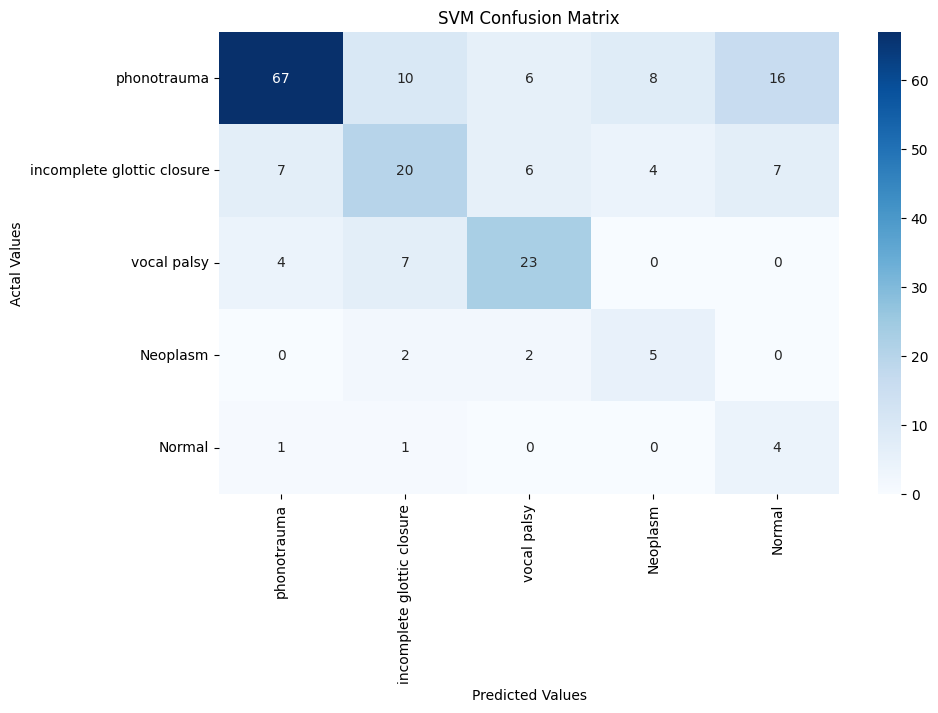

XGB
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       107
           1       0.61      0.50      0.55        44
           2       0.65      0.65      0.65        34
           3       0.11      0.11      0.11         9
           4       0.67      0.33      0.44         6

    accuracy                           0.68       200
   macro avg       0.56      0.48      0.51       200
weighted avg       0.67      0.68      0.67       200

UAR: 0.4827866349031825
specificity:  0.9948453608247423
sensitivity:  0.3333333333333333
AUC 0.7319830034817665


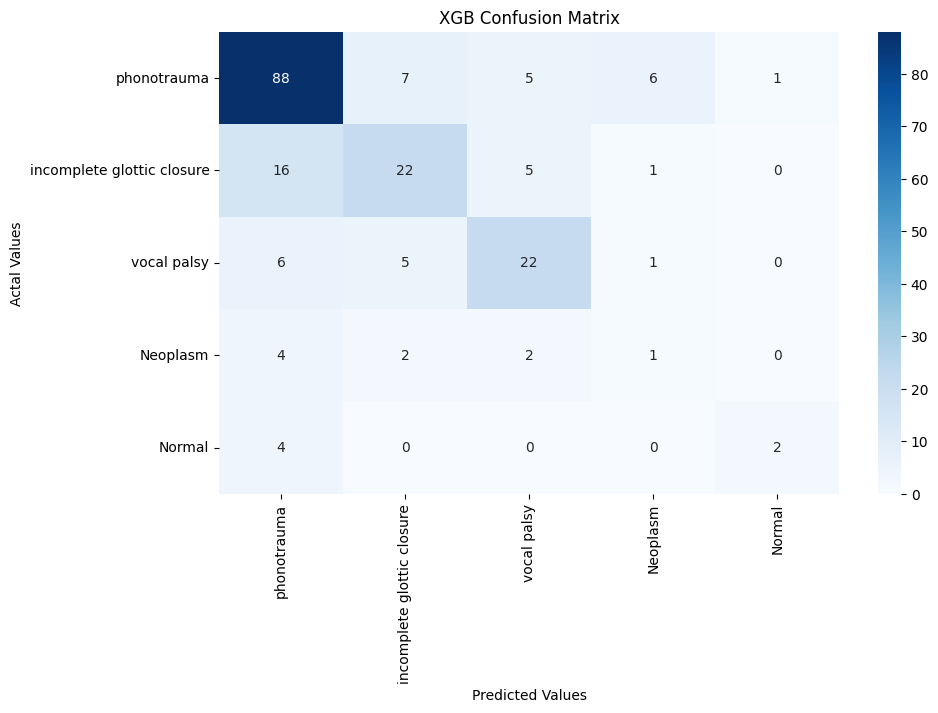

ExtraTrees
              precision    recall  f1-score   support

           0       0.82      0.63      0.71       107
           1       0.52      0.52      0.52        44
           2       0.65      0.71      0.68        34
           3       0.20      0.44      0.28         9
           4       0.18      0.50      0.26         6

    accuracy                           0.60       200
   macro avg       0.47      0.56      0.49       200
weighted avg       0.68      0.60      0.63       200

UAR: 0.5598444588823919
specificity:  0.9278350515463918
sensitivity:  0.5
AUC 0.8555359925996264


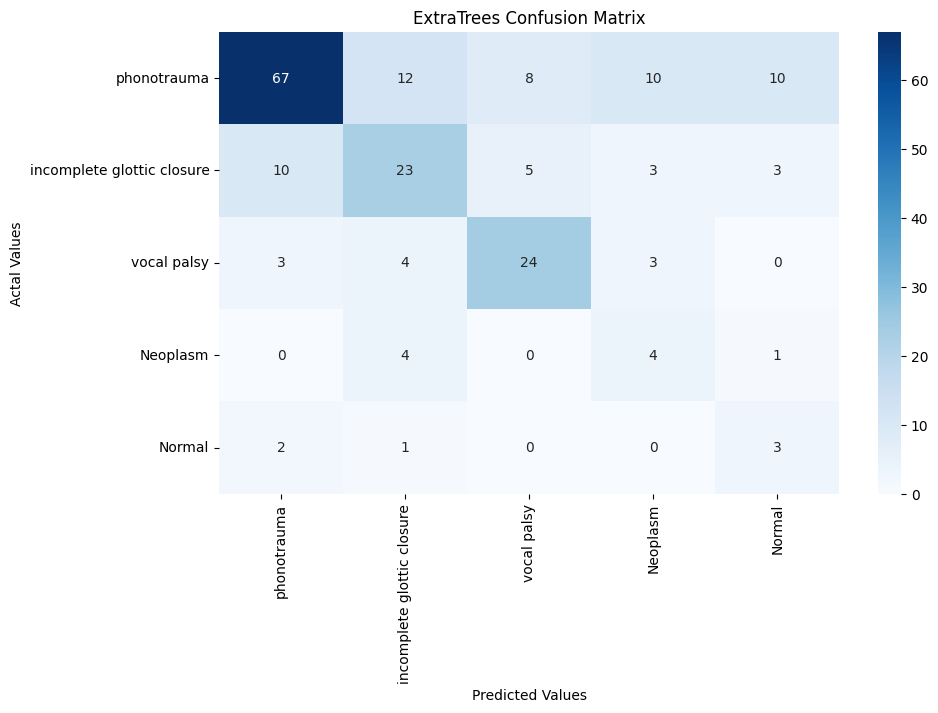

In [47]:
svm_Pred = svm.predict(clinical_x_val)
svm_proba = []
for i in range(svm_Pred.shape[0]):  # svm的預測結果直接是類別，因此我們自行定義了其預測機率值
    if svm_Pred[i]==0:
        pp=[0.9,0.05,0.05,0,0]
    elif svm_Pred[i]==1:
        pp=[0.05,0.7,0.05,0.1,0.1]
    elif svm_Pred[i]==2:
        pp=[0.05,0.05,0.7,0.1,0.1]
    elif svm_Pred[i]==3:
        pp=[0.05,0.05,0.05,0.8,0.05]
    elif svm_Pred[i]==4:
        pp=[0.05,0.05,0.05,0.05,0.8]
    svm_proba.append(pp)
svm_proba = np.array(svm_proba)
ETC_Pred = clf.predict(clinical_x_val)
ETC_proba = clf.predict_proba(clinical_x_val)
xgb_Pred = xgb.predict(clinical_x_val)
xgb_proba = xgb.predict_proba(clinical_x_val)


print("SVM")
print(classification_report(y_val, svm_Pred))
class_name = ['phonotrauma', 'incomplete glottic closure', 'vocal palsy', 'Neoplasm', 'Normal']
conf = confusion_matrix(y_val, svm_Pred)
recall = recall_score(y_val, svm_Pred, average=None)
uar = recall.mean()
specificity, sensitivity = specificity_sensitivity(y_val, svm_Pred)
print("UAR:",uar)
print("specificity: ",specificity)
print("sensitivity: ",sensitivity)
print("AUC",roc_auc_score(y_val, svm_proba,multi_class='ovo'))

plt.figure(figsize = (10, 6))
sns.heatmap(cm_dfsinc, annot=True,fmt="d", cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

print("XGB")
print(classification_report(y_val, xgb_Pred))
class_name = ['phonotrauma', 'incomplete glottic closure', 'vocal palsy', 'Neoplasm', 'Normal']
conf = confusion_matrix(y_val, xgb_Pred)
cm_dfsinc = pd.DataFrame(conf,index = class_name, columns = class_name)
recall = recall_score(y_val, xgb_Pred, average=None)
uar = recall.mean()
specificity, sensitivity = specificity_sensitivity(y_val, xgb_Pred)
print("UAR:",uar)
print("specificity: ",specificity)
print("sensitivity: ",sensitivity)
print("AUC",roc_auc_score(y_val, xgb_proba,multi_class='ovo'))

plt.figure(figsize = (10, 6))
sns.heatmap(cm_dfsinc, annot=True,fmt="d", cmap='Blues')
plt.title('XGB Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

print("ExtraTrees")
print(classification_report(y_val, ETC_Pred))
class_name = ['phonotrauma', 'incomplete glottic closure', 'vocal palsy', 'Neoplasm', 'Normal']
conf = confusion_matrix(y_val, ETC_Pred)
cm_dfsinc = pd.DataFrame(conf,index = class_name, columns = class_name)
recall = recall_score(y_val, ETC_Pred, average=None)
uar = recall.mean()
specificity, sensitivity = specificity_sensitivity(y_val, ETC_Pred)
print("UAR:",uar)
print("specificity: ",specificity)
print("sensitivity: ",sensitivity)
print("AUC",roc_auc_score(y_val, ETC_proba,multi_class='ovo'))

plt.figure(figsize = (10, 6))
sns.heatmap(cm_dfsinc, annot=True,fmt="d", cmap='Blues')
plt.title('ExtraTrees Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

              precision    recall  f1-score   support

           0       0.65      0.92      0.76       107
           1       0.61      0.25      0.35        44
           2       0.77      0.59      0.67        34
           3       0.00      0.00      0.00         9
           4       0.83      0.83      0.83         6

    accuracy                           0.67       200
   macro avg       0.57      0.52      0.52       200
weighted avg       0.64      0.67      0.62       200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


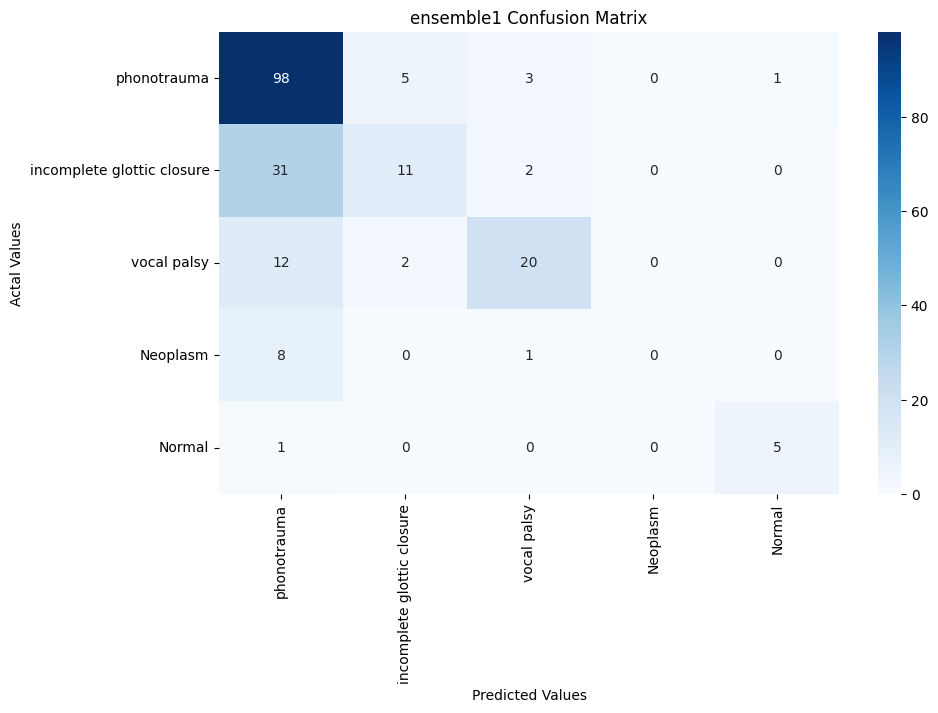

UAR: 0.517491295583654
specificity:  0.9948453608247423
sensitivity:  0.8333333333333334
AUC 0.8672477362038935


In [48]:
ens1 = sincnet_predict + MelS_predict
y_Pred = np.argmax(ens1, axis=-1)
print(classification_report(y_val, y_Pred))
class_name = ['phonotrauma', 'incomplete glottic closure', 'vocal palsy', 'Neoplasm', 'Normal']
conf = confusion_matrix(y_val, y_Pred)
cm_dfsinc = pd.DataFrame(conf,index = class_name, columns = class_name)
plt.figure(figsize = (10, 6))
sns.heatmap(cm_dfsinc, annot=True,fmt="d", cmap='Blues')
plt.title('ensemble1 Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
recall = recall_score(y_val, y_Pred, average=None)
uar = recall.mean()
specificity, sensitivity = specificity_sensitivity(y_val, y_Pred)
print("UAR:",uar)
print("specificity: ",specificity)
print("sensitivity: ",sensitivity)
print("AUC",roc_auc_score(y_val, ens1/2,multi_class='ovo'))

              precision    recall  f1-score   support

           0       0.67      0.83      0.74       107
           1       0.50      0.39      0.44        44
           2       0.61      0.50      0.55        34
           3       0.00      0.00      0.00         9
           4       0.50      0.50      0.50         6

    accuracy                           0.63       200
   macro avg       0.46      0.44      0.45       200
weighted avg       0.59      0.63      0.60       200



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


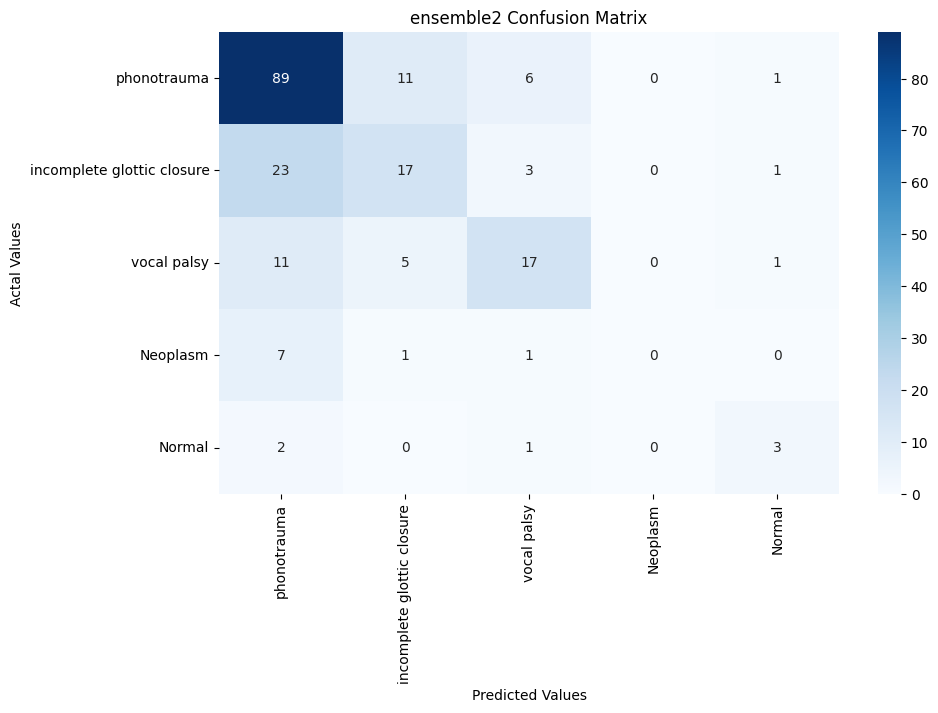

UAR: 0.44362786745964317
specificity:  0.9845360824742269
sensitivity:  0.5
AUC 0.8110008366605399


In [49]:
ens2 = sincnet_predict + mfcc_predict 
y_Pred = np.argmax(ens2, axis=-1)
print(classification_report(y_val, y_Pred))
class_name = ['phonotrauma', 'incomplete glottic closure', 'vocal palsy', 'Neoplasm', 'Normal']
conf = confusion_matrix(y_val, y_Pred)
cm_dfsinc = pd.DataFrame(conf,index = class_name, columns = class_name)
plt.figure(figsize = (10, 6))
sns.heatmap(cm_dfsinc, annot=True,fmt="d", cmap='Blues')
plt.title('ensemble2 Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

recall = recall_score(y_val, y_Pred, average=None)
uar = recall.mean()
specificity, sensitivity = specificity_sensitivity(y_val, y_Pred)
print("UAR:",uar)
print("specificity: ",specificity)
print("sensitivity: ",sensitivity)
print("AUC",roc_auc_score(y_val, ens2/2,multi_class='ovo'))

              precision    recall  f1-score   support

           0       0.61      0.91      0.73       107
           1       0.40      0.09      0.15        44
           2       0.75      0.53      0.62        34
           3       0.50      0.11      0.18         9
           4       0.60      0.50      0.55         6

    accuracy                           0.61       200
   macro avg       0.57      0.43      0.45       200
weighted avg       0.58      0.61      0.55       200



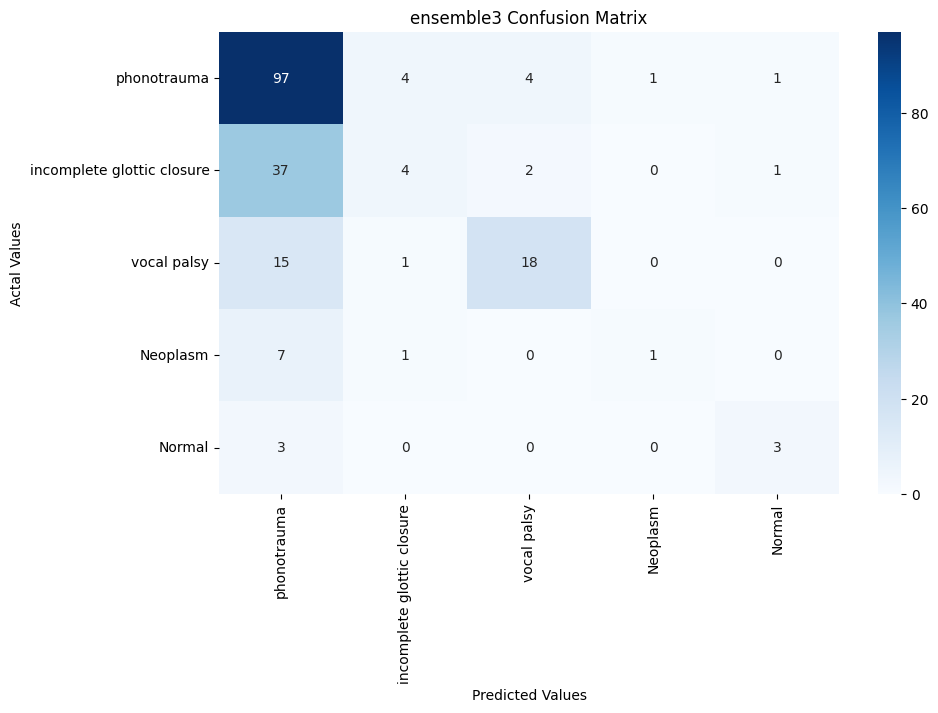

UAR: 0.4275948045601702
specificity:  0.9896907216494846
sensitivity:  0.5
AUC 0.8000730574019469


In [50]:
ens3 = MelS_predict + mfcc_predict 
y_Pred = np.argmax(ens3, axis=-1)
print(classification_report(y_val, y_Pred))
class_name = ['phonotrauma', 'incomplete glottic closure', 'vocal palsy', 'Neoplasm', 'Normal']
conf = confusion_matrix(y_val, y_Pred)
cm_dfsinc = pd.DataFrame(conf,index = class_name, columns = class_name)
plt.figure(figsize = (10, 6))
sns.heatmap(cm_dfsinc, annot=True,fmt="d", cmap='Blues')
plt.title('ensemble3 Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
recall = recall_score(y_val, y_Pred, average=None)
uar = recall.mean()
specificity, sensitivity = specificity_sensitivity(y_val, y_Pred)
print("UAR:",uar)
print("specificity: ",specificity)
print("sensitivity: ",sensitivity)
print("AUC",roc_auc_score(y_val, ens3/2,multi_class='ovo'))

              precision    recall  f1-score   support

           0       0.84      0.64      0.73       107
           1       0.50      0.45      0.48        44
           2       0.62      0.68      0.65        34
           3       0.29      0.56      0.38         9
           4       0.17      0.67      0.27         6

    accuracy                           0.60       200
   macro avg       0.48      0.60      0.50       200
weighted avg       0.68      0.60      0.63       200



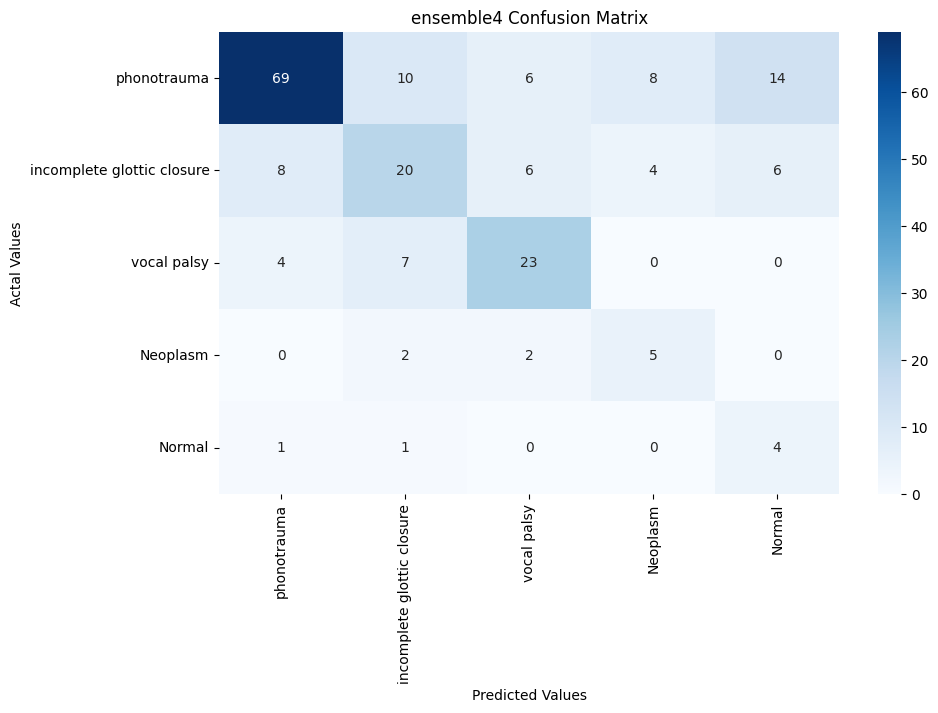

UAR: 0.5996196156174165
specificity:  0.8969072164948454
sensitivity:  0.6666666666666666
AUC 0.8713520351027222


In [51]:
ens4 = sincnet_predict + svm_proba + ETC_proba + xgb_proba
y_Pred = np.argmax(ens4, axis=-1)
print(classification_report(y_val, y_Pred))
class_name = ['phonotrauma', 'incomplete glottic closure', 'vocal palsy', 'Neoplasm', 'Normal']
conf = confusion_matrix(y_val, y_Pred)
cm_dfsinc = pd.DataFrame(conf,index = class_name, columns = class_name)
plt.figure(figsize = (10, 6))
sns.heatmap(cm_dfsinc, annot=True,fmt="d", cmap='Blues')
plt.title('ensemble4 Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
recall = recall_score(y_val, y_Pred, average=None)
uar = recall.mean()
specificity, sensitivity = specificity_sensitivity(y_val, y_Pred)
print("UAR:",uar)
print("specificity: ",specificity)
print("sensitivity: ",sensitivity)
print("AUC",roc_auc_score(y_val, ens4/4,multi_class='ovo'))

              precision    recall  f1-score   support

           0       0.84      0.67      0.75       107
           1       0.55      0.50      0.52        44
           2       0.69      0.74      0.71        34
           3       0.29      0.56      0.38         9
           4       0.19      0.67      0.30         6

    accuracy                           0.64       200
   macro avg       0.51      0.63      0.53       200
weighted avg       0.71      0.64      0.66       200



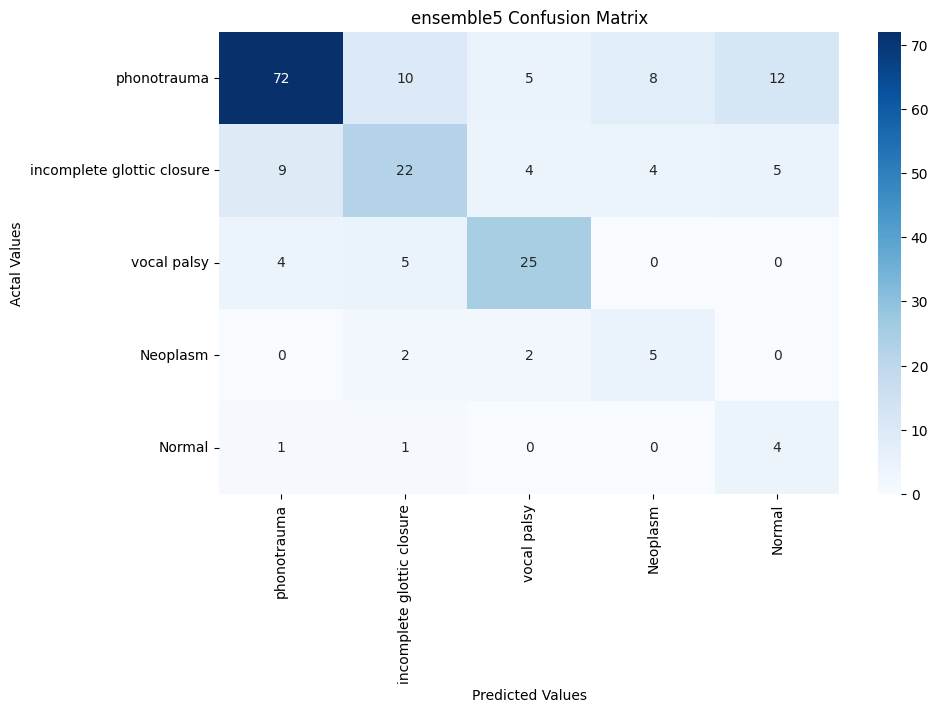

UAR: 0.6260827072261926
specificity:  0.9123711340206185
sensitivity:  0.6666666666666666
AUC 0.8607358401682206


In [52]:
ens5 = mfcc_predict + svm_proba + ETC_proba + xgb_proba
y_Pred = np.argmax(ens5, axis=-1)
print(classification_report(y_val, y_Pred))
class_name = ['phonotrauma', 'incomplete glottic closure', 'vocal palsy', 'Neoplasm', 'Normal']
conf = confusion_matrix(y_val, y_Pred)
cm_dfsinc = pd.DataFrame(conf,index = class_name, columns = class_name)
plt.figure(figsize = (10, 6))
sns.heatmap(cm_dfsinc, annot=True,fmt="d", cmap='Blues')
plt.title('ensemble5 Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
recall = recall_score(y_val, y_Pred, average=None)
uar = recall.mean()
specificity, sensitivity = specificity_sensitivity(y_val, y_Pred)
print("UAR:",uar)
print("specificity: ",specificity)
print("sensitivity: ",sensitivity)
print("AUC",roc_auc_score(y_val, ens5/4,multi_class='ovo'))

              precision    recall  f1-score   support

           0       0.84      0.76      0.79       107
           1       0.60      0.48      0.53        44
           2       0.75      0.79      0.77        34
           3       0.33      0.56      0.42         9
           4       0.24      0.67      0.35         6

    accuracy                           0.69       200
   macro avg       0.55      0.65      0.57       200
weighted avg       0.73      0.69      0.70       200



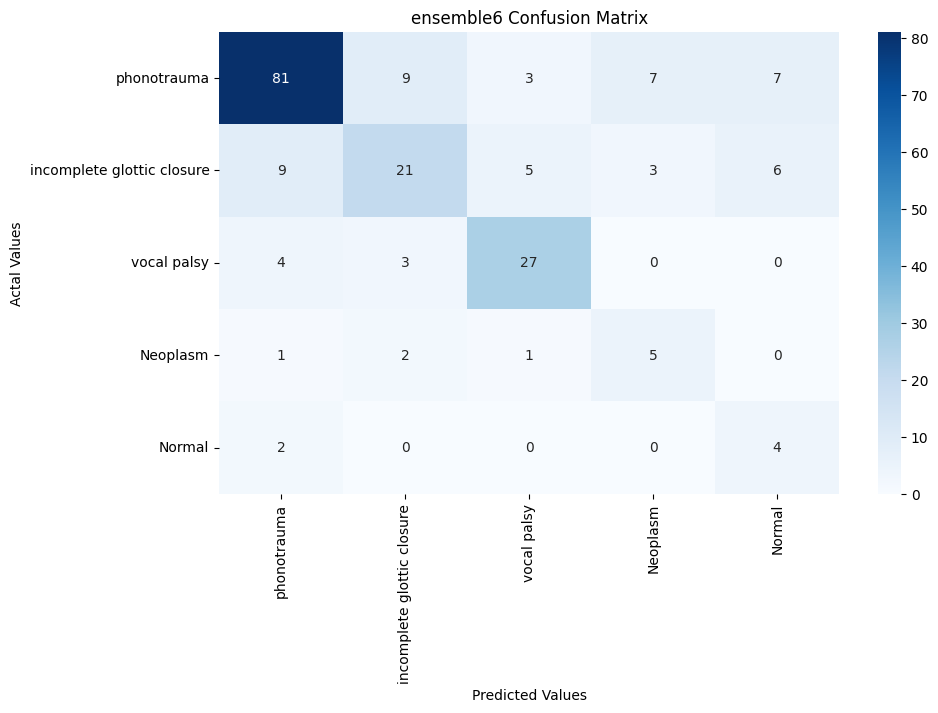

UAR: 0.650124388469633
specificity:  0.9329896907216495
sensitivity:  0.6666666666666666
AUC 0.8974716817247053


In [53]:
ens6 = MelS_predict + svm_proba + ETC_proba + xgb_proba
y_Pred = np.argmax(ens6, axis=-1)
print(classification_report(y_val, y_Pred))
class_name = ['phonotrauma', 'incomplete glottic closure', 'vocal palsy', 'Neoplasm', 'Normal']
conf = confusion_matrix(y_val, y_Pred)
cm_dfsinc = pd.DataFrame(conf,index = class_name, columns = class_name)
plt.figure(figsize = (10, 6))
sns.heatmap(cm_dfsinc, annot=True,fmt="d", cmap='Blues')
plt.title('ensemble6 Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
recall = recall_score(y_val, y_Pred, average=None)
uar = recall.mean()
specificity, sensitivity = specificity_sensitivity(y_val, y_Pred)
print("UAR:",uar)
print("specificity: ",specificity)
print("sensitivity: ",sensitivity)
print("AUC",roc_auc_score(y_val, ens6/4,multi_class='ovo'))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       107
           1       0.67      0.55      0.60        44
           2       0.87      0.79      0.83        34
           3       0.50      0.33      0.40         9
           4       0.50      0.67      0.57         6

    accuracy                           0.76       200
   macro avg       0.67      0.64      0.65       200
weighted avg       0.75      0.76      0.75       200



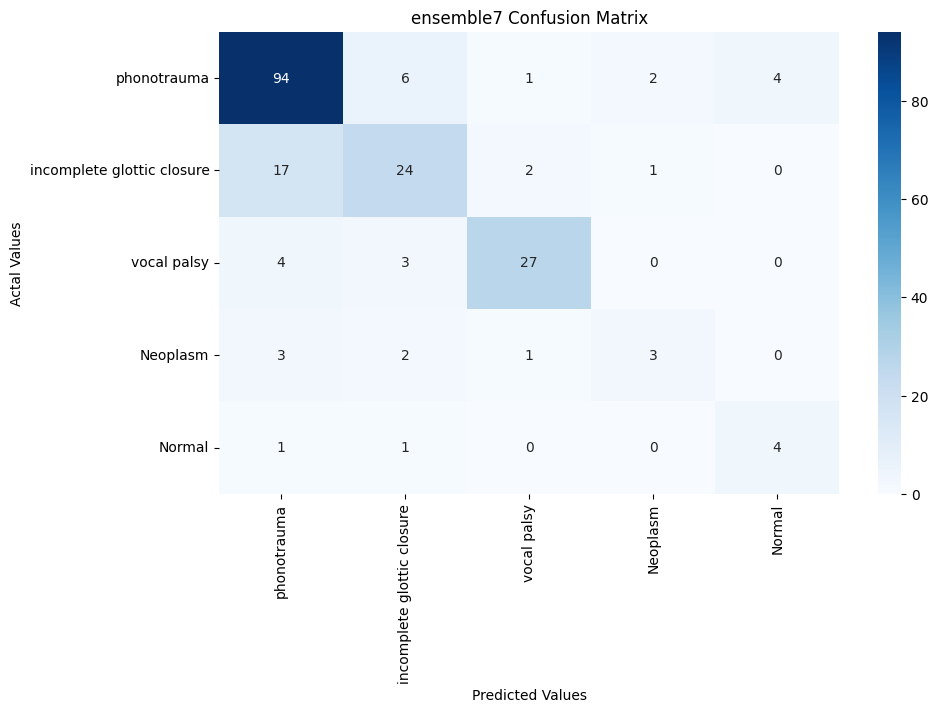

UAR: 0.643615373082113
specificity:  0.979381443298969
sensitivity:  0.6666666666666666
AUC 0.8909906051536067


In [54]:
ens7 = sincnet_predict + svm_proba + ETC_proba + mfcc_predict + xgb_proba + MelS_predict
y_Pred = np.argmax(ens7, axis=-1)
print(classification_report(y_val, y_Pred))
class_name = ['phonotrauma', 'incomplete glottic closure', 'vocal palsy', 'Neoplasm', 'Normal']
conf = confusion_matrix(y_val, y_Pred)
cm_dfsinc = pd.DataFrame(conf,index = class_name, columns = class_name)
plt.figure(figsize = (10, 6))
sns.heatmap(cm_dfsinc, annot=True,fmt="d", cmap='Blues')
plt.title('ensemble7 Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
recall = recall_score(y_val, y_Pred, average=None)
uar = recall.mean()
specificity, sensitivity = specificity_sensitivity(y_val, y_Pred)
print("UAR:",uar)
print("specificity: ",specificity)
print("sensitivity: ",sensitivity)
print("AUC",roc_auc_score(y_val, ens7/6,multi_class='ovo'))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79       107
           1       0.55      0.48      0.51        44
           2       0.74      0.76      0.75        34
           3       0.33      0.56      0.42         9
           4       0.29      0.67      0.40         6

    accuracy                           0.69       200
   macro avg       0.55      0.64      0.57       200
weighted avg       0.71      0.69      0.69       200



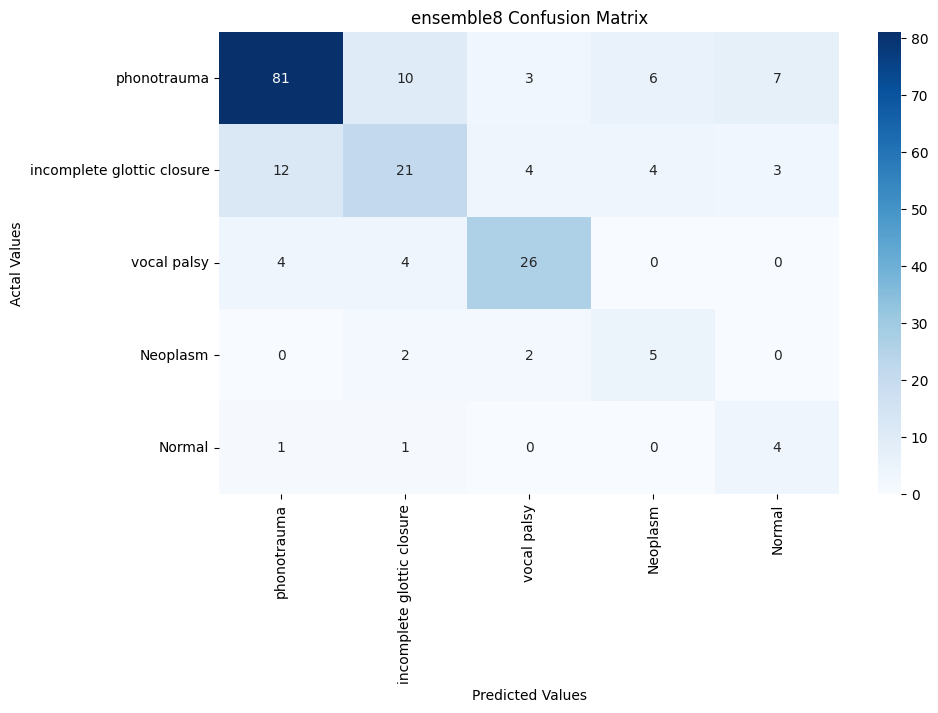

UAR: 0.6442420355284566
specificity:  0.9484536082474226
sensitivity:  0.6666666666666666
AUC 0.8853950444522187


In [55]:
ens8 = sincnet_predict + 2*svm_proba + ETC_proba + mfcc_predict + xgb_proba + MelS_predict
y_Pred = np.argmax(ens8, axis=-1)
print(classification_report(y_val, y_Pred))
class_name = ['phonotrauma', 'incomplete glottic closure', 'vocal palsy', 'Neoplasm', 'Normal']
conf = confusion_matrix(y_val, y_Pred)
cm_dfsinc = pd.DataFrame(conf,index = class_name, columns = class_name)
plt.figure(figsize = (10, 6))
sns.heatmap(cm_dfsinc, annot=True,fmt="d", cmap='Blues')
plt.title('ensemble8 Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
recall = recall_score(y_val, y_Pred, average=None)
uar = recall.mean()
specificity, sensitivity = specificity_sensitivity(y_val, y_Pred)
print("UAR:",uar)
print("specificity: ",specificity)
print("sensitivity: ",sensitivity)
print("AUC",roc_auc_score(y_val, ens8/7,multi_class='ovo'))

In [61]:
def get_roc(pos_prob,y_true):
    pos = y_true[y_true==4]
    neg = y_true[y_true!=4]
    threshold = np.sort(pos_prob)[::-1]    
    y = y_true[pos_prob.argsort()[::-1]]
    tpr_all = [0] ; fpr_all = [0]
    tpr = 0 ; fpr = 0
    x_step = 1/float(len(neg))
    y_step = 1/float(len(pos))
    y_sum = 0                               
    for i in range(len(threshold)):
        if y[i] == 4:
            tpr += y_step
            tpr_all.append(tpr)
            fpr_all.append(fpr)
        else:
            fpr += x_step
            fpr_all.append(fpr)
            tpr_all.append(tpr)
            y_sum += tpr
    return tpr_all,fpr_all,y_sum*x_step 

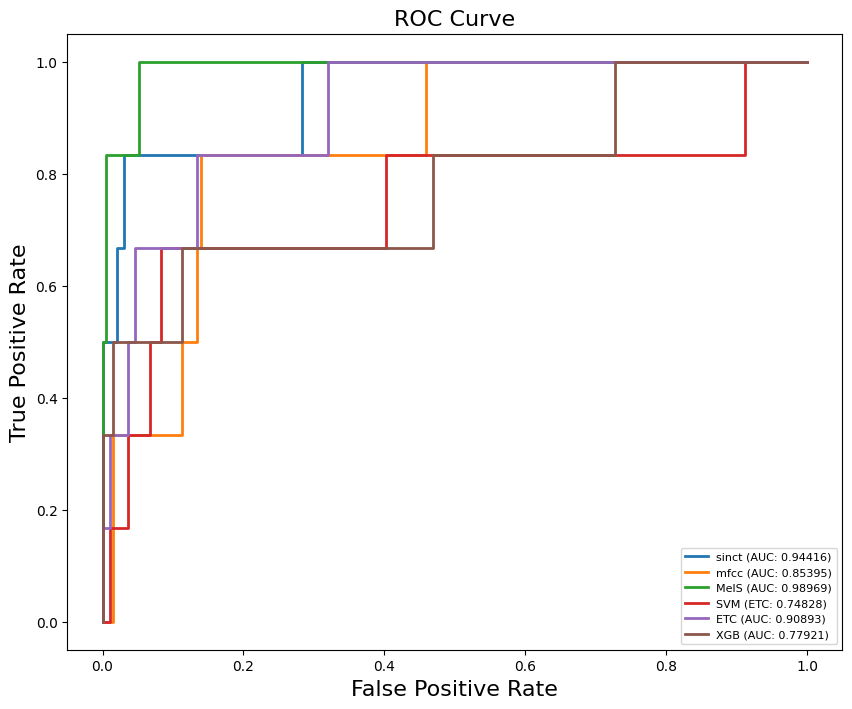

In [59]:
sinc_pos_prob = sincnet_predict[:,-1]
mfcc_pos_prob = mfcc_predict[:,-1]
MelS_pos_prob = MelS_predict[:,-1]
svm_pos_prob = svm_proba[:,-1]
ETC_pos_prob = ETC_proba[:,-1]
xgb_pos_prob = xgb_proba[:,-1]

plt.figure(figsize = (10, 8))
tpr,fpr,auc = get_roc(sinc_pos_prob,y_val)
plt.plot(fpr,tpr,label="sinct (AUC: {:.5f})".format(auc),linewidth=2)

tpr,fpr,auc = get_roc(mfcc_pos_prob,y_val)
plt.plot(fpr,tpr,label="mfcc (AUC: {:.5f})".format(auc),linewidth=2)

tpr,fpr,auc = get_roc(MelS_pos_prob,y_val)
plt.plot(fpr,tpr,label="MelS (AUC: {:.5f})".format(auc),linewidth=2)

tpr,fpr,auc = get_roc(svm_pos_prob,y_val)
plt.plot(fpr,tpr,label="SVM (ETC: {:.5f})".format(auc),linewidth=2)

tpr,fpr,auc = get_roc(ETC_pos_prob,y_val)
plt.plot(fpr,tpr,label="ETC (AUC: {:.5f})".format(auc),linewidth=2)

tpr,fpr,auc = get_roc(xgb_pos_prob,y_val)
plt.plot(fpr,tpr,label="XGB (AUC: {:.5f})".format(auc),linewidth=2)

plt.xlabel("False Positive Rate",fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.title("ROC Curve",fontsize=16)
plt.legend(loc="lower right",fontsize=8)

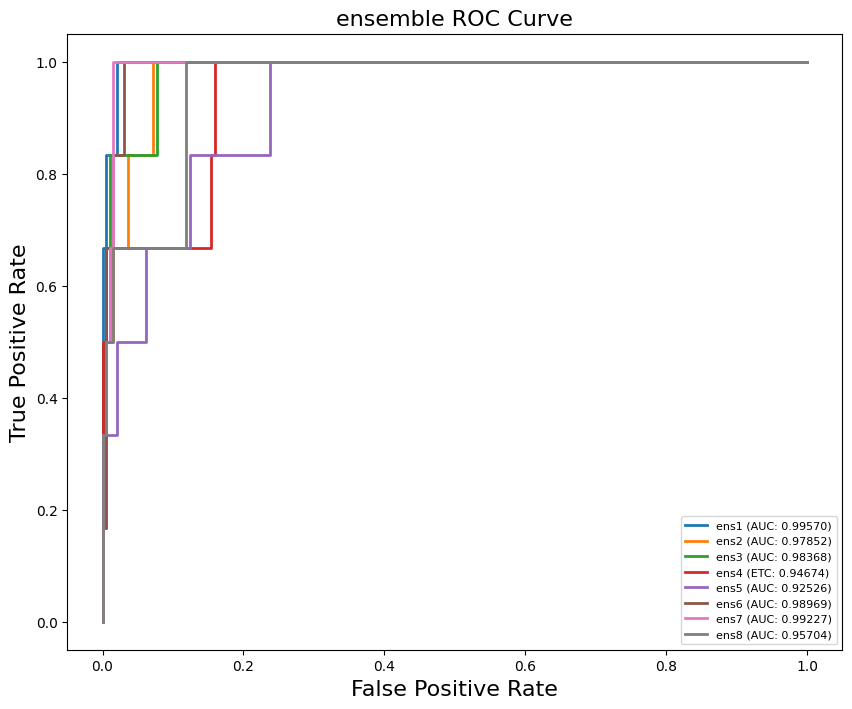

In [60]:
ens1_pos_prob = ens1[:,-1]
ens2_pos_prob = ens2[:,-1]
ens3_pos_prob = ens3[:,-1]
ens4_pos_prob = ens4[:,-1]
ens5_pos_prob = ens5[:,-1]
ens6_pos_prob = ens6[:,-1]
ens7_pos_prob = ens7[:,-1]
ens8_pos_prob = ens8[:,-1]

plt.figure(figsize = (10, 8))
tpr,fpr,auc = get_roc(ens1_pos_prob,y_val)
plt.plot(fpr,tpr,label="ens1 (AUC: {:.5f})".format(auc),linewidth=2)

tpr,fpr,auc = get_roc(ens2_pos_prob,y_val)
plt.plot(fpr,tpr,label="ens2 (AUC: {:.5f})".format(auc),linewidth=2)

tpr,fpr,auc = get_roc(ens3_pos_prob,y_val)
plt.plot(fpr,tpr,label="ens3 (AUC: {:.5f})".format(auc),linewidth=2)

tpr,fpr,auc = get_roc(ens4_pos_prob,y_val)
plt.plot(fpr,tpr,label="ens4 (ETC: {:.5f})".format(auc),linewidth=2)

tpr,fpr,auc = get_roc(ens5_pos_prob,y_val)
plt.plot(fpr,tpr,label="ens5 (AUC: {:.5f})".format(auc),linewidth=2)

tpr,fpr,auc = get_roc(ens6_pos_prob,y_val)
plt.plot(fpr,tpr,label="ens6 (AUC: {:.5f})".format(auc),linewidth=2)

tpr,fpr,auc = get_roc(ens7_pos_prob,y_val)
plt.plot(fpr,tpr,label="ens7 (AUC: {:.5f})".format(auc),linewidth=2)

tpr,fpr,auc = get_roc(ens8_pos_prob,y_val)
plt.plot(fpr,tpr,label="ens8 (AUC: {:.5f})".format(auc),linewidth=2)

plt.xlabel("False Positive Rate",fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.title("ensemble ROC Curve",fontsize=16)
plt.legend(loc="lower right",fontsize=8)